In [197]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import pypfopt 
import matplotlib.pyplot as plt

from pypfopt import black_litterman, plotting, objective_functions, risk_models
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

In [198]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"] # Initial asset universe
start_date = '2013-01-01'
end_date = '2024-01-01'

In [199]:
data = yf.download(tickers, start=start_date, end=end_date)
data.to_csv("./Data/historical_data.csv")

closing_prices = data["Adj Close"]

returns = np.log(closing_prices / closing_prices.shift(1).dropna())

def get_market_prices_and_caps(tickers, start_date, end_date):
    # VOO is Vanguard S&P 500 ETF
    market_prices = yf.download("VOO", start=start_date, end=end_date)["Adj Close"]
    # market_returns = np.log(market_prices / market_prices.shift(1)).dropna() 

    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)  # Get market cap, with None if missing

    return market_prices, market_caps

closing_prices.tail()

[*********************100%***********************]  7 of 7 completed


Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Date,,,,,,,
2023-12-22 00:00:00+00:00,139.600006,153.419998,47.365639,352.329163,48.819527,23.209999,252.539993
2023-12-26 00:00:00+00:00,143.410004,153.410004,49.832600,353.764832,49.268425,23.590000,256.609985
2023-12-27 00:00:00+00:00,146.070007,153.339996,50.089161,356.755829,49.406395,23.730000,261.440002
2023-12-28 00:00:00+00:00,148.759995,153.380005,49.724056,357.244354,49.511375,23.540001,253.179993
2023-12-29 00:00:00+00:00,147.410004,151.940002,49.585903,352.897491,49.511375,23.459999,248.479996


<Axes: >

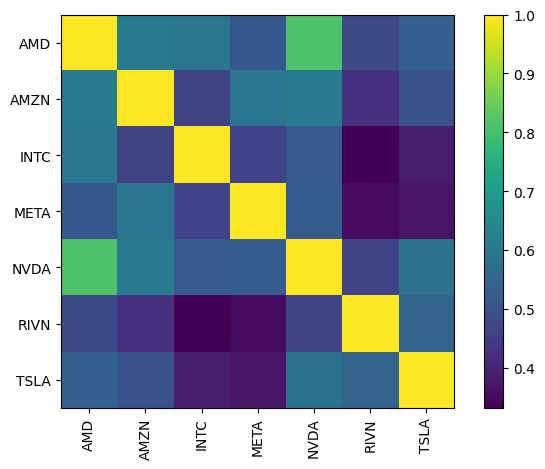

In [200]:
covariance_matrix = returns.cov()
plotting.plot_covariance(covariance_matrix, plot_correlation=True)

In [201]:
covariance_matrix

Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Ticker,,,,,,,
AMD,0.001181,0.000547,0.000489,0.000602,0.000990,0.000892,0.000709
AMZN,0.000547,0.000687,0.000286,0.000529,0.000567,0.000604,0.000501
INTC,0.000489,0.000286,0.000563,0.000376,0.000436,0.000425,0.000348
META,0.000602,0.000529,0.000376,0.001150,0.000633,0.000644,0.000476
NVDA,0.000990,0.000567,0.000436,0.000633,0.001252,0.000897,0.000791
RIVN,0.000892,0.000604,0.000425,0.000644,0.000897,0.002920,0.001124
TSLA,0.000709,0.000501,0.000348,0.000476,0.000791,0.001124,0.001462


[*********************100%***********************]  1 of 1 completed


<Axes: ylabel='Ticker'>

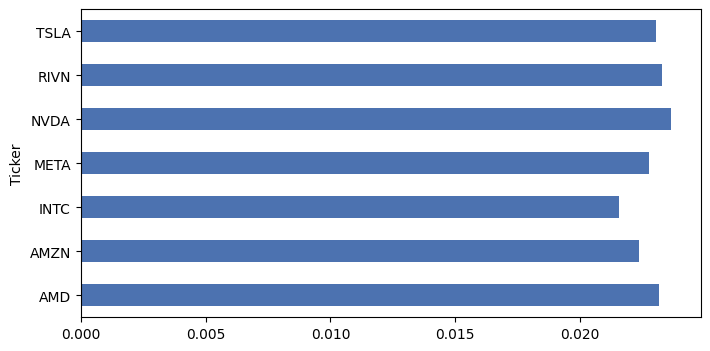

In [202]:
# Standard delta and prior
market_prices, market_caps = get_market_prices_and_caps(tickers, start_date, end_date)
delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(market_caps, delta, covariance_matrix)

market_caps
market_prices
prior.plot.barh(figsize=(8,4))

In [ ]:
# view_dict = {"TSLA": 0.015, "NVDA": 0.03, "AMZN": -0.15, "META": 0.095, "RIVN": -0.055, "INTC": -0.035, "AMD": 0.025} # these must equate to 1 you idiot
relative_views = np.array([0.20, 0.15, 0.10, 0.07, 0.25]).reshape(-1, 1)
confidences = [0.3, 0.25, 0.4, 0.3, 0.4]
tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"]
picking_matrix = np.array(
    [
        # five views (rows) and seven assets (columns)
        [1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, -1, 0, 0],
        [0, 0, -1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1] # dont think these are mapped correctly
    ]
)

bl = BlackLittermanModel(covariance_matrix, pi=prior, absolute_views=None, Q=relative_views, P=picking_matrix, omega="idzorek", view_confidences=confidences)

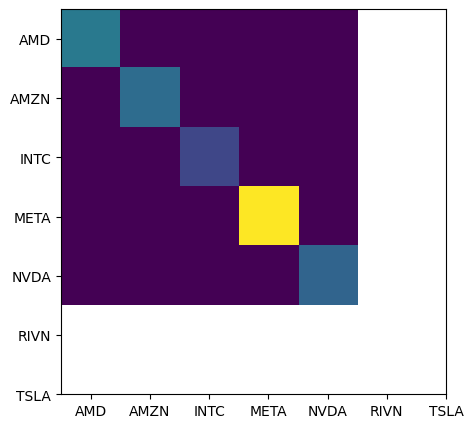

array([1.37811152e-04, 1.20868366e-04, 7.20948334e-05, 3.40718064e-04,
       1.09667024e-04])

In [229]:
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

np.diag(bl.omega)

In [230]:
bl_returns = bl.bl_returns()
bl_returns

Ticker
AMD     0.087604
AMZN    0.086751
INTC    0.044742
META    0.093680
NVDA    0.074276
RIVN    0.102849
TSLA    0.120752
dtype: float64

In [238]:
# Create a series for relative views with NaN for missing tickers
relative_views_series = pd.Series(np.nan, index=tickers)
relative_views_series[:len(relative_views)] = relative_views.flatten()

# Create the DataFrame
returns_df = pd.DataFrame([prior, bl_returns, relative_views_series], index=["Prior", "Posterior", "Views"]).T
returns_df

,Prior,Posterior,Views
AMD,0.023153,0.087604,NaN
AMZN,0.022365,0.086751,0.10
INTC,0.021548,0.044742,NaN
META,0.022742,0.093680,0.07
NVDA,0.023644,0.074276,0.15
RIVN,0.023288,0.102849,0.25
TSLA,0.023035,0.120752,0.20


<Axes: >

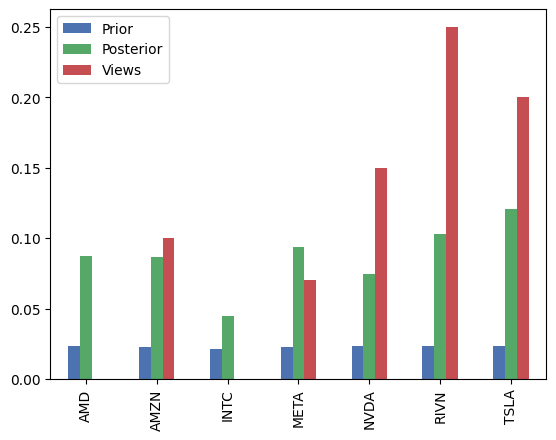

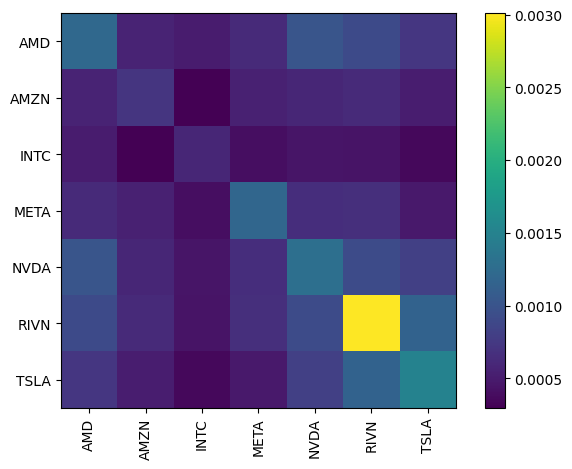

In [239]:
# visualisation of above
returns_df.plot.bar()

# Standard posterior covariance matrix
posterior_cov = bl.bl_cov()
plotting.plot_covariance(posterior_cov)

In [240]:
# Standard efficient frontier and cleaned weights
ef = EfficientFrontier(bl_returns, posterior_cov)
# min_vol_weights = ef.min_volatility() # max_sharpe not working. look into this
max_sharpe_weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
cleaned_weights

OrderedDict([('AMD', 0.0),
             ('AMZN', 0.38691),
             ('INTC', 0.0),
             ('META', 0.21424),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.39885)])

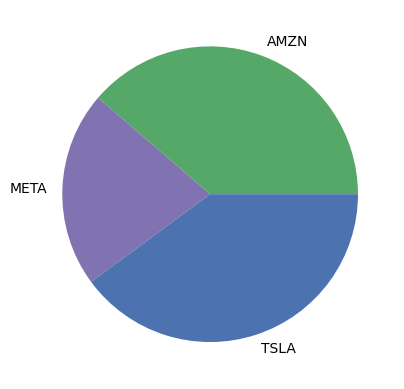

In [241]:
model_1_allocations = pd.Series(cleaned_weights).plot.pie()

In [245]:
ef.portfolio_performance(verbose=True)

Expected annual return: 10.2%
Annual volatility: 2.7%
Sharpe Ratio: 3.02


(0.10179707423212069, 0.027048339684048208, 3.024107031617937)